In [1]:
import __main__
print(__main__.__package__)

None


In [2]:
import sys
import os

sys.path.append(os.path.abspath("..")) 

In [3]:
dataloader_cfg = {
    "data_dir": "/home/cc/efficient-rsnn-bmi/data/datasets",
    "ratio_val": 0.1,
    "random_val": False,
    "extend_data": True,
    "sample_duration": 2.0,
    "remove_segments_inactive": False,
    "p_drop": 0.0,
    "p_insert": 0.0,
    "jitter_sigma": 0.0,
    "dtype": "float32",
    "dt": 4e-3,
}

In [4]:
from omegaconf import OmegaConf

dataloader_cfg = OmegaConf.create(dataloader_cfg)

In [5]:
import torch

dtype = getattr(torch, dataloader_cfg.dtype)

In [6]:
from efficient_rsnn_bmi.core.dataloader import get_dataloader

dataloader = get_dataloader(dataloader_cfg, dtype=dtype)

In [7]:
from pathlib import Path
from hydra.utils import to_absolute_path

model_dir = Path(to_absolute_path("../states/baseline/pretrained/2025-06-06/16-46-36/")) / "pretrained_on_indy_best_model.pth"

In [8]:
print(model_dir)

/home/cc/efficient-rsnn-bmi/notebooks/../states/baseline/pretrained/2025-06-06/16-46-36/pretrained_on_indy_best_model.pth


In [9]:
model_dir = "/home/cc/efficient-rsnn-bmi/states/baseline/pretrained/2025-06-06/16-46-36/pretrained_on_indy_best_model.pth"

In [10]:
model_type = 'baselineRSNN'

In [12]:
# state_dict_path = [Path(f) for f in model_dir.iterdir() if model_type in f.name]

# state_dict_path

In [13]:
filename = "indy_20170131_02.mat"

In [14]:
train_dat, val_data, test_dat = dataloader.get_single_session_data(filename)

Loading indy_20170131_02.mat
[2025-06-10 12:57:04] [INFO] [efficient_rsnn_bmi.base.dataloader] - Extending data...


In [ ]:
print(f"Length of train data: {len(train_dat)}")
print(f"Length of val data: {len(val_data)}")
print(f"Length of test data: {len(test_dat)}")
print(f"Dimension of 1st spike train data: {(train_dat[0][0].shape)}")
print(f"Dimension of 1st of label train data: {(train_dat[0][1].shape)}")
print(f"Dimension of 1st spike val data: {(val_data[0][0].shape)}")
print(f"Dimension of 1st of label val data: {(val_data[0][1].shape)}")
print(f"Dimension of 1st spike test data: {(test_dat[0][0].shape)}")
print(f"Dimension of 1st of label test data: {(test_dat[0][1].shape)}")

Length of train data: 1242
Length of val data: 267
Length of test data: 1
Dimension of 1st spike train data: torch.Size([500, 96])
Dimension of 1st of label train data: torch.Size([500, 2])
Dimension of 1st spike val data: torch.Size([500, 96])
Dimension of 1st of label val data: torch.Size([500, 2])
Dimension of 1st spike test data: torch.Size([52116, 96])
Dimension of 1st of label test data: torch.Size([52116, 2])


In [ ]:
print(f"Data type of 1st spike train data: {train_dat[0][0].dtype}")
print(f"Data type of 1st label train data: {train_dat[0][1].dtype}")
print(f"Data type of 1st spike val data: {val_data[0][0].dtype}")
print(f"Data type of 1st label val data: {val_data[0][1].dtype}")
print(f"Data type of 1st spike test data: {test_dat[0][0].dtype}")
print(f"Data type of 1st label test data: {test_dat[0][1].dtype}")

Data type of 1st spike train data: torch.float32
Data type of 1st label train data: torch.float32
Data type of 1st spike val data: torch.float32
Data type of 1st label val data: torch.float32
Data type of 1st spike test data: torch.float32
Data type of 1st label test data: torch.float32


In [15]:
from efficient_rsnn_bmi.neurobench.result_handler import BenchmarkResultsHandler

results = BenchmarkResultsHandler()

In [16]:
nb_time_steps = int(dataloader_cfg.sample_duration / dataloader_cfg.dt)

nb_time_steps

500

In [17]:
nb_outputs = train_dat[0][1].shape[1]

nb_outputs

2

In [18]:
nb_inputs = train_dat[0][0].shape[1]

nb_inputs

96

In [19]:
training_config = {
    "training": {
        "batch_size": 250,
        "SG_beta": 20,
        "LB_L2_strength": 100,
        "LB_L2_thresh": 1e-3,
        "UB_L2_strength": 0.01,
        "UB_L2_thresh": 10,
    }
}

In [20]:
training_config = OmegaConf.create(training_config)

In [21]:
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of GPUs: 2
GPU 0: Tesla P100-PCIE-16GB
GPU 1: Tesla P100-PCIE-16GB


In [22]:
device = "cuda"

In [23]:
from efficient_rsnn_bmi.experiments.models.rsnn.rsnn import BaselineRecurrentSpikingModel

model = BaselineRecurrentSpikingModel(
    batch_size = training_config.training.batch_size,
    nb_time_steps = nb_time_steps,
    nb_inputs = nb_inputs,
    device = device,
    dtype = dtype,
)

In [24]:
model.summary()


# Model summary

## Groups

## Connections


In [25]:
model_config = {
    "model": {
        "stochastic": False,
        "dropout_p": 0.3,
        "nb_hidden": 1,
        "hidden_size": [64],
        "recurrent": [True],
        "multiple_readout": False,
        "tau_mem_readout": 50e-3,
        "tau_syn_readout": 10e-3,
        "tau_mem": 20e-3,
        "tau_syn": 10e-3,
        "het_timescales": True,
        "het_timescales_readout": True,
        "learn_timescales": True,
        "learn_timescales_readout": True,
        "delta_synapse": False,
        "is_half": True
    }
}

In [26]:
model_config = OmegaConf.create(model_config)

In [27]:
# this is the get activation one
import stork

activation_function = stork.activations.CustomSpike

In [28]:
if model_config.model.stochastic:
    activation_function.escape_noise_type = "sigmoid"
else:
    activation_function.escape_noise_type = "step"

In [29]:
activation_function.escape_noise_params = {"beta": training_config.training.SG_beta}
activation_function.surrogate_type = "SuperSpike"
activation_function.surrogate_params = {"beta": training_config.training.SG_beta}

In [30]:
regs = []

In [31]:
regLB = stork.regularizers.LowerBoundL2(
    strength = training_config.training.LB_L2_strength,
    threshold = training_config.training.LB_L2_thresh,
    dims = False,
)

In [32]:
regUB = stork.regularizers.UpperBoundL2(
    strength = training_config.training.UB_L2_strength,
    threshold = training_config.training.UB_L2_thresh,
    dims = 1,
)

In [33]:
regs.append(regLB)
regs.append(regUB)

In [34]:
regs

In [35]:
def compute_input_firing_rates(data, cfg):
    mean1 = 0
    mean2 = 0

    for i in range(len(data)):
        mean1 += torch.sum(data[i][0][:, :96]) / cfg.sample_duration / 96
        try:
            mean2 += torch.sum(data[i][0][:, 96:]) / cfg.sample_duration / 96
        except:
            continue

    mean1 /= len(data)
    mean2 /= len(data)

    # For LOCO
    print (data[0][0].shape)
    if data[0][0].shape[1] == 192:
        return mean1, mean2

    # FOR INDY
    else:
        return mean1, None

In [36]:
mean1, mean2 = compute_input_firing_rates(train_dat, dataloader_cfg)

torch.Size([500, 96])


In [37]:
print(mean1, mean2)

tensor(10.6100) None


In [38]:
initializers_config = {
    "initializer": {
        "compute_nu": True,
        "sigma_u": 0.5,
        "nu": 20,
        "alpha": 0.9
    }
}

In [39]:
initializers_config = OmegaConf.create(initializers_config)

In [40]:
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer
)

hidden_init = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=initializers_config.initializer.sigma_u,
    nu=mean1,
    timestep=dataloader_cfg.dt,
    alpha=initializers_config.initializer.alpha,
    dtype=dtype,
)

readout_init = DistInitializer(
    dist=torch.distributions.Normal(0, 1),
    scaling="1/sqrt(k)",
    dtype=dtype,
)

In [41]:
from stork.nodes import InputGroup

input_group = model.add_group(
    InputGroup(
       shape=nb_inputs,
        dropout_p=model_config.model.dropout_p,
    )
)

In [42]:
current_src_grp = input_group

current_src_grp

InputGroup(
  (dropout): Dropout(p=0.3, inplace=False)
)

In [43]:
# check this again later after working (CUSTOM READOUT GROUP)

from efficient_rsnn_bmi.base.readout import CustomReadoutGroup

def get_custom_readouts(cfg):
    ro_list = []
    for ro, specs in cfg.model["readouts"].items():
        if "tau_mem" in specs:
            tau_mem = specs["tau_mem"]
        else:
            tau_mem = cfg.model.tau_mem_readout
        if "tau_syn" in specs:
            tau_syn = specs["tau_syn"]
        else:
            tau_syn = cfg.model.tau_syn_readout

        if specs["type"] == "default":
            ro_group = CustomReadoutGroup(
                cfg.data.nb_outputs,
                tau_mem=tau_mem,
                tau_syn=tau_syn,
                het_timescales=cfg.model.het_timescales_readout,
                learn_timescales=cfg.model.learn_timescales_readout,
                initial_state=-1e-2,
                is_delta_syn=False,
            )
        elif specs["type"] == "delta":
            ro_group = CustomReadoutGroup(
                cfg.data.nb_outputs,
                tau_mem=tau_mem,
                tau_syn=tau_syn,
                het_timescales=cfg.model.het_timescales_readout,
                learn_timescales=cfg.model.learn_timescales_readout,
                initial_state=-1e-2,
                is_delta_syn=True,
            )

        ro_group.set_name(ro)
        ro_list.append(ro_group)

    return ro_list

In [44]:
from stork.layers import Layer
from stork.connections import Connection
from efficient_rsnn_bmi.base.lif import CustomLIFGroup
from efficient_rsnn_bmi.base.readout import CustomReadoutGroup

for i in range (model_config.model.nb_hidden):
    hidden_layer = Layer(
        name = f"hidden_{i}",
        model = model,
        size = model_config.model.hidden_size[i],
        input_group = input_group,
        recurrent = model_config.model.recurrent[i],
        regs = regs,
        neuron_class = CustomLIFGroup,
        neuron_kwargs={
            "tau_mem": model_config.model.tau_mem,
            "tau_syn": model_config.model.tau_syn,
            "activation": activation_function,
            "dropout_p": model_config.model.dropout_p,
            "het_timescales": model_config.model.het_timescales, # Didn't found
            "learn_timescales": model_config.model.learn_timescales,
            "is_delta_syn": model_config.model.delta_synapse, # Didn't found
        },
    )

    current_src_grp = hidden_layer.output_group
    print(current_src_grp)

    hidden_init.initialize(hidden_layer)

    if i == 0 and nb_inputs == 192 and train_dat is not None:
        with torch.no_grad():
            hidden_layer.connections[0].weight[:, :96] /= mean2 / mean1
        
    # Add single RO group
    readout_group = model.add_group(
        CustomReadoutGroup(
            nb_outputs,
            tau_mem = model_config.model.tau_mem_readout,
            tau_syn = model_config.model.tau_syn_readout,
            het_timescales = model_config.model.het_timescales_readout,
            learn_timescales = model_config.model.learn_timescales_readout,
            initial_state = -1e-2,
            is_delta_syn = model_config.model.delta_synapse,
        )
    )

    print("Readout group shape: ", readout_group.shape)
    print("Current source group shape: ", current_src_grp.shape)
    print(current_src_grp, readout_group)
    con_ro = model.add_connection(
        Connection(current_src_grp, readout_group, dtype=dtype)
    )

    readout_init.initialize(con_ro)

CustomLIFGroup(
  (dropout): Dropout(p=0.3, inplace=False)
)
Readout group shape:  (2,)
Current source group shape:  (64,)
CustomLIFGroup(
  (dropout): Dropout(p=0.3, inplace=False)
) CustomReadoutGroup()


In [45]:
model.summary()


# Model summary

## Groups
Input, (96,)
hidden_0, (64,)
Readout, (2,)

## Connections
Connection(
  (src): InputGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=96, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=64, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomReadoutGroup()
  (op): Linear(in_features=64, out_features=2, bias=False)
)


In [46]:
from efficient_rsnn_bmi.base.loss import RootMeanSquareError

loss_class = RootMeanSquareError()
# Mask Early Timestep later

In [47]:
from stork.optimizers import SMORMS3

opt_kwargs = {
    "lr": 2e-3
}

opt_kwargs["eps"] = 1e-5 if dtype == torch.float16 else 1e-16

opt = SMORMS3

In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
scheduler_kwargs = {"T_max": 200} # nb of epoch train

In [49]:
# Make sure this later (Worker Init Seeding)

import numpy as np
import random

def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)

In [50]:
from stork.generators import StandardGenerator

generator = StandardGenerator(
    nb_workers=2,
    worker_init_fn=worker_init_fn,
)

In [ ]:
model.configure(
    input=model.groups[0],
    output=model.groups[-1],
    loss_stack=loss_class,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=opt_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    time_step=dataloader_cfg.dt,
)

In [52]:
model.summary()


# Model summary

## Groups
Input, (96,)
hidden_0, (64,)
Readout, (2,)

## Connections
Connection(
  (src): InputGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=96, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=64, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomReadoutGroup()
  (op): Linear(in_features=64, out_features=2, bias=False)
)


In [53]:
loaded_model_state = torch.load(model_dir)

In [54]:
model.load_state_dict(loaded_model_state)

<All keys matched successfully>

In [55]:
model = model.half()

In [56]:
test_dat.dtype = torch.float16

In [57]:
eval_loss_class = RootMeanSquareError()

In [58]:
# Configure model for evaluation
model.set_nb_steps(test_dat[0][0].shape[0])
model.loss_stack = eval_loss_class

In [75]:
from efficient_rsnn_bmi.neurobench.wrappers.stork_wrapper import StorkModel

stork_test_model = StorkModel(model)

In [60]:
test_set_loader = torch.utils.data.DataLoader(
    test_dat,
    batch_size=1,
    shuffle=False,
)

In [61]:
for x, y in test_set_loader:
    print("x dtype:", x.dtype)
    print("y dtype:", y.dtype)
    break

x dtype: torch.float16
y dtype: torch.float16


In [62]:
print(test_dat[0][0].dtype)
print(test_dat[0][1].dtype)

torch.float16
torch.float16


In [73]:
import torch

from neurobench.metrics.workload import R2 as R2Base
from neurobench.metrics.utils.decorators import check_shapes

class R2(R2Base):

    def __init__(self):
        super().__init__()
    
    @check_shapes
    def __call__(self, model, preds, data):
        self.reset()
        labels = data[1].to(preds.device)
        # print(f"Prediction: {preds}")
        # print(f"Prediction: {preds.shape}")
        # print(f"Data: {data}")
        # print(f"Data Shape: {data.shape}")
        self.x_sum_squares += torch.sum(
            (labels.squeeze()[:, 0] - preds.squeeze()[:, 0]) ** 2
        ).item()
        self.y_sum_squares += torch.sum(
            (labels.squeeze()[:, 1] - preds.squeeze()[:, 1]) ** 2
        ).item()

        self.x_labels = self.x_labels.to(labels.device)
        self.y_labels = self.y_labels.to(labels.device)

        if self.x_labels is None:
            self.x_labels = labels.squeeze()[:, 0]
            self.y_labels = labels.squeeze()[:, 1]
        else:
            self.x_labels = torch.cat(
                (self.x_labels, labels.squeeze()[:, 0])
            )
            self.y_labels = torch.cat(
                (self.y_labels, labels.squeeze()[:, 1])
            )

        return self.compute()



In [64]:
from neurobench.metrics.workload import SynapticOperations as SynapticOperationsBased
from neurobench.metrics.utils.layers import single_layer_MACs

class SynapticOperations(SynapticOperationsBased):
    def __init__(self):
        super().__init__()

    def __call__(self, model, preds, data):
        for hook in model.connection_hooks:
            inputs = hook.inputs  # copy of the inputs, delete hooks after
            for spikes in inputs:
                # spikes is batch, features, see snntorchmodel wrappper
                # for single_in in spikes:
                if len(spikes) == 1:
                    spikes = spikes[0]
                hook.hook.remove()
                operations, spiking = single_layer_MACs(spikes, hook.layer)
                total_ops, _ = single_layer_MACs(spikes, hook.layer, total=True)
                self.total_synops += total_ops
                if spiking:
                    self.AC += operations
                else:
                    self.MAC += operations
                hook.register_hook()
        # ops_per_sample = ops / data[0].size(0)
        self.total_samples += data[0].squeeze().size(0)
        return self.compute()

In [65]:
from neurobench.metrics.workload import ActivationSparsity as ActivationSparsityBased

class ActivationSparsity(ActivationSparsityBased):
    def __init__(self):
        super().__init__()

    def __call__(self, model, preds, data):
        """
        Compute activation sparsity.

        Args:
            model: A NeuroBenchModel.
            preds: A tensor of model predictions.
            data: A tuple of data and labels.
        Returns:
            float: Activation sparsity

        """
        # TODO: for a spiking model, based on number of spikes over all timesteps over all samples from all layers
        #       Standard FF ANN depends on activation function, ReLU can introduce sparsity.
        total_spike_num = 0  # Count of non-zero activations
        total_neuro_num = 0  # Count of all activations

        print(model.activation_hooks)
        for hook in model.activation_hooks:
            # Skip layers with no outputs
            print(hook.layer)
            if isinstance(hook.layer, CustomLIFGroup):
                spikes = hook.layer.get_flattened_out_sequence()
                print(spikes)
                spikes_num, neuro_num = torch.count_nonzero(spikes).item(), torch.numel(
                    spikes
                )
                total_spike_num += spikes_num
                total_neuro_num += neuro_num
            else:
                for (
                    spikes
                ) in hook.activation_outputs:  # do we need a function rather than a member
                    spike_num, neuro_num = torch.count_nonzero(spikes).item(), torch.numel(
                        spikes
                    )
                    total_spike_num += spike_num
                    total_neuro_num += neuro_num

        # Compute sparsity
        if total_neuro_num == 0:  # Prevent division by zero
            return 0.0

        sparsity = (total_neuro_num - total_spike_num) / total_neuro_num
        return sparsity

In [76]:
from neurobench.metrics.static import (
    Footprint,
    ConnectionSparsity,
)

# from efficient_rsnn_bmi.neurobench.metrics.activation_sparsity import ActivationSparsity
# from efficient_rsnn_bmi.neurobench.metrics.r2 import R2
# from efficient_rsnn_bmi.neurobench.metrics.syn_ops import SynapticOperations

# from efficient_rsnn_bmi.neurobench.metrics.r2 import R2

static_metrics = []
# static_metrics = [Footprint, ConnectionSparsity]
# static_metrics = []
# workload_metrics = [R2, ActivationSparsity, SynapticOperations]
workload_metrics = [R2]

In [101]:
val_data.dtype = torch.float16

Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Evaluation Score: [1.59484863e-01 6.76512718e-06 6.59423828e-01 6.90429688e-01
 6.75048828e-01]


/home/cc/efficient-rsnn-bmi/efficient_rsnn_bmi/utils/plotting.py:263: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0][-1].legend()


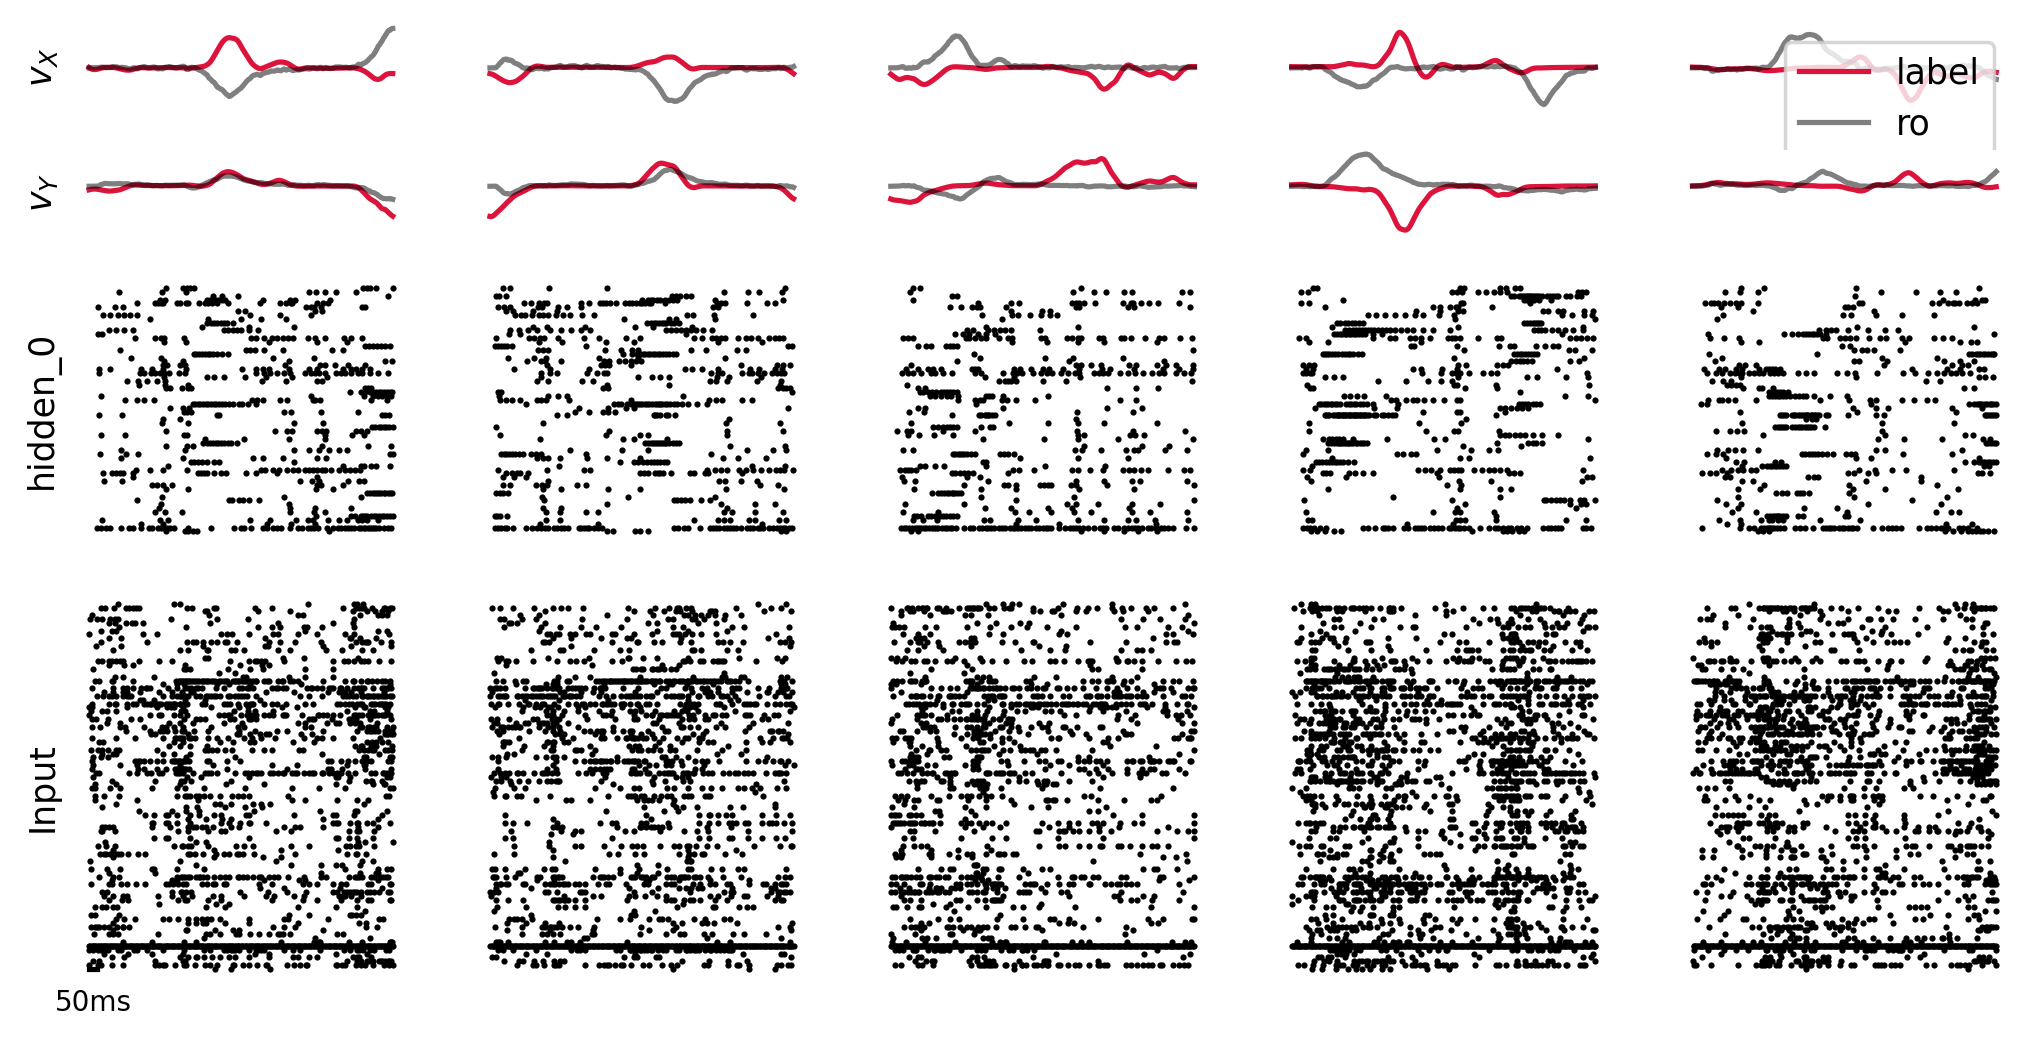

In [102]:
from efficient_rsnn_bmi.utils.plotting import plot_activity_snapshot

fig, ax = plot_activity_snapshot(
    model,
    val_data,
    save_path= "testing"
)

In [71]:
stork_test_model.activation_layers()[0].name

'hidden_0'

In [78]:
from neurobench.benchmarks import Benchmark

benchmark = Benchmark(
    stork_test_model,
    test_set_loader,
    [],
    [],
    [static_metrics, workload_metrics],
)

In [79]:
result = benchmark.run(verbose=True, device=device)

result

Running benchmark


100%|██████████| 1/1 [00:45<00:00, 45.80s/it]


Batch num 1/1
{'R2': 0.7217938899993896}


{'R2': 0.7217938899993896}

In [70]:
import json

def benchmark_in_background():
    result = benchmark.run(verbose=True, device=device)

    with open("benchmark_results_dump.json", "w") as f:
        json.dump(result, f, indent=2)

    benchmark.save_benchmark_results(
        "benchmark_results.json",
        "json",
    )
    
    print(result)

In [ ]:
from threading import Thread

thread = Thread(target=benchmark_in_background)
thread.start()

Running benchmark


100%|██████████| 1/1 [04:10<00:00, 250.36s/it]


Batch num 1/1
{'R2': 0.7491962909698486, 'ActivationSparsity': 0.0, 'SynapticOperations': {'Effective_MACs': 0.0, 'Effective_ACs': 304.8286898457288, 'Dense': 10368.0}}
Results saved to benchmark_results.json.json
{'R2': 0.7491962909698486, 'ActivationSparsity': 0.0, 'SynapticOperations': {'Effective_MACs': 0.0, 'Effective_ACs': 304.8286898457288, 'Dense': 10368.0}}
